In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from typing import Tuple
import optuna
import re
from pathlib import Path


In [68]:
sns.set_theme(style='whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Leitura e pré-processamento de dados.

In [69]:
def read_csv_folder(input_path: Path) -> pd.DataFrame:
    """
    Lê todos os arquivos CSV na pasta especificada e concatena em um único DataFrame.
    """
    df_full = pd.DataFrame()
    
    if not input_path.exists():
        raise FileNotFoundError(f"O diretório {input_path} não existe.")
    
    if not any(input_path.glob('*.csv')):
        raise FileNotFoundError(f"Nenhum arquivo CSV encontrado no diretório {input_path}.")
    for file in input_path.glob('*.csv'):
        print(f"Processando arquivo: {file.name}")
        city_regex = r'(\w+)_\d{4}.csv'
        match = re.match(city_regex, file.name)
        city_name = match.group(1) if match else 'Desconhecido'
        print(f"Nome da cidade: {city_name}")
        df = pd.read_csv(file, skiprows=2)
        df['City'] = city_name
        df_full = pd.concat([df_full, df], ignore_index=True)
    return df_full


In [70]:
df  = read_csv_folder(Path('data/'))

Processando arquivo: Natal_2020.csv
Nome da cidade: Natal
Processando arquivo: Natal_2021.csv
Nome da cidade: Natal
Processando arquivo: Natal_2022.csv
Nome da cidade: Natal
Processando arquivo: Natal_2023.csv
Nome da cidade: Natal
Processando arquivo: Natal_2024.csv
Nome da cidade: Natal


In [71]:
df['Year'].unique()

array([2020, 2021, 2022, 2023, 2024])

In [72]:
def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(['Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag', 'Cloud Fill Flag', 'Aerosol Optical Depth','Alpha','SSA','Asymmetry'], axis = 1)
    df = df.dropna()
    # Combine year, month, day, hour into a single datetime column
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    # Extract useful time-based features
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['HourOfDay'] = df['Datetime'].dt.hour
    df['Month'] = df['Datetime'].dt.month
    # Optionally, drop original columns if not needed
    df = df.drop(['Month', 'Day', 'Hour', 'Datetime'], axis=1)
    return df

In [73]:
def data_scaling_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    # Codificar a coluna 'City' usando One-Hot Encoding
    city_encoded = one_hot_encoder.fit_transform(df[['City']])
    city_encoded_df = pd.DataFrame(city_encoded, columns=one_hot_encoder.get_feature_names_out(['City']), index=df.index)
    # Concatenar as colunas codificadas com o restante do DataFrame (exceto 'City')
    df_no_city = df.drop(['City'], axis=1)
    df_all = pd.concat([df_no_city, city_encoded_df], axis=1)
    scaler = MinMaxScaler()
    df_all['DayOfYear'] = np.sin(df_all['DayOfYear'] * (2 * np.pi / 365))  # Normalização do dia do ano
    df_all['HourOfDay'] = np.sin(df_all['HourOfDay'] * (2 * np.pi / 24))  # Normalização da hora do dia
    columns_to_scale = [col for col in df_all.columns if col not in ['Year', 'DayOfYear', 'HourOfDay']]
    df_all[columns_to_scale] = scaler.fit_transform(df_all[columns_to_scale])
    # Uso dos dados até 2023 para treino e 2024 para teste.
    df_train = df_all[df_all['Year'] <= 2022]
    df_test = df_all[df_all['Year'] >= 2023]
    #Remove a coluna 'Year' dos dataframes.
    df_train = df_train.drop(['Year'], axis=1)
    df_test = df_test.drop(['Year'], axis=1)
    # Reset index for all dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    return df_train, df_test

In [74]:
df = data_preprocessing(df)
df.tail(10)

,Year,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,City,DayOfYear,HourOfDay
87590,2024,29.3,23.8,309,72.23,1007,4.2,116,0.0,Natal,366,19
87591,2024,28.8,23.8,190,74.41,1008,4.2,116,0.0,Natal,366,19
87592,2024,28.4,24.0,82,77.28,1008,4.2,115,0.0,Natal,366,20
87593,2024,28.2,24.1,8,78.25,1009,4.2,115,0.0,Natal,366,20
87594,2024,28.0,24.3,0,80.35,1009,4.3,115,0.0,Natal,366,21
87595,2024,27.8,24.3,0,81.28,1009,4.3,115,0.0,Natal,366,21
87596,2024,27.7,24.5,0,82.56,1010,4.3,115,0.0,Natal,366,22
87597,2024,27.7,24.5,0,82.56,1010,4.4,115,0.0,Natal,366,22
87598,2024,27.6,24.5,0,83.49,1010,4.4,115,0.0,Natal,366,23
87599,2024,27.6,24.5,0,83.49,1010,4.4,115,0.0,Natal,366,23


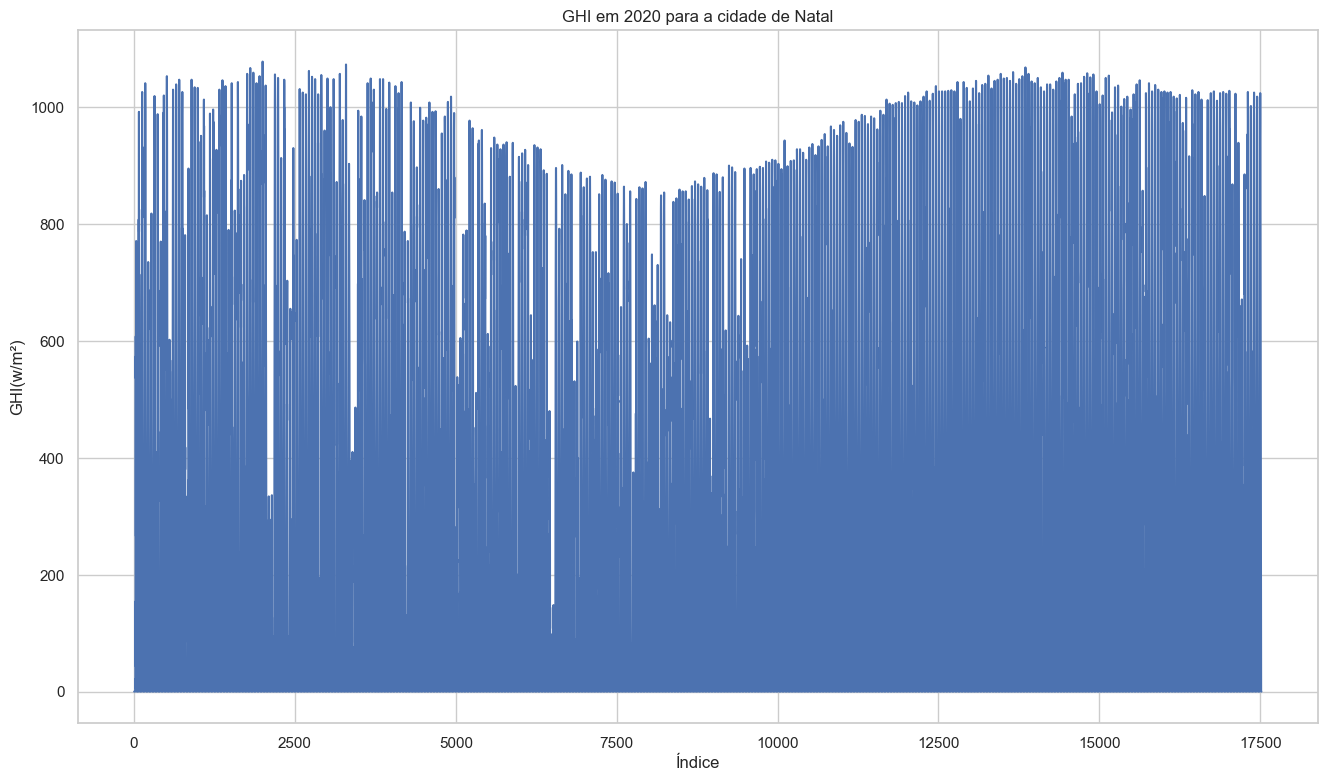

In [75]:
# Plota a coluna 'GHI' para o ano de 2020
plt.figure(figsize=(16, 9))
sns.lineplot(data=df[df['Year'] == 2020].reset_index(), x='index', y='GHI')
plt.title('GHI em 2020 para a cidade de Natal')
plt.xlabel('Índice')
plt.ylabel('GHI(w/m²)')
plt.savefig('GHI_2020_Natal.png', dpi=300, bbox_inches='tight')
plt.show()


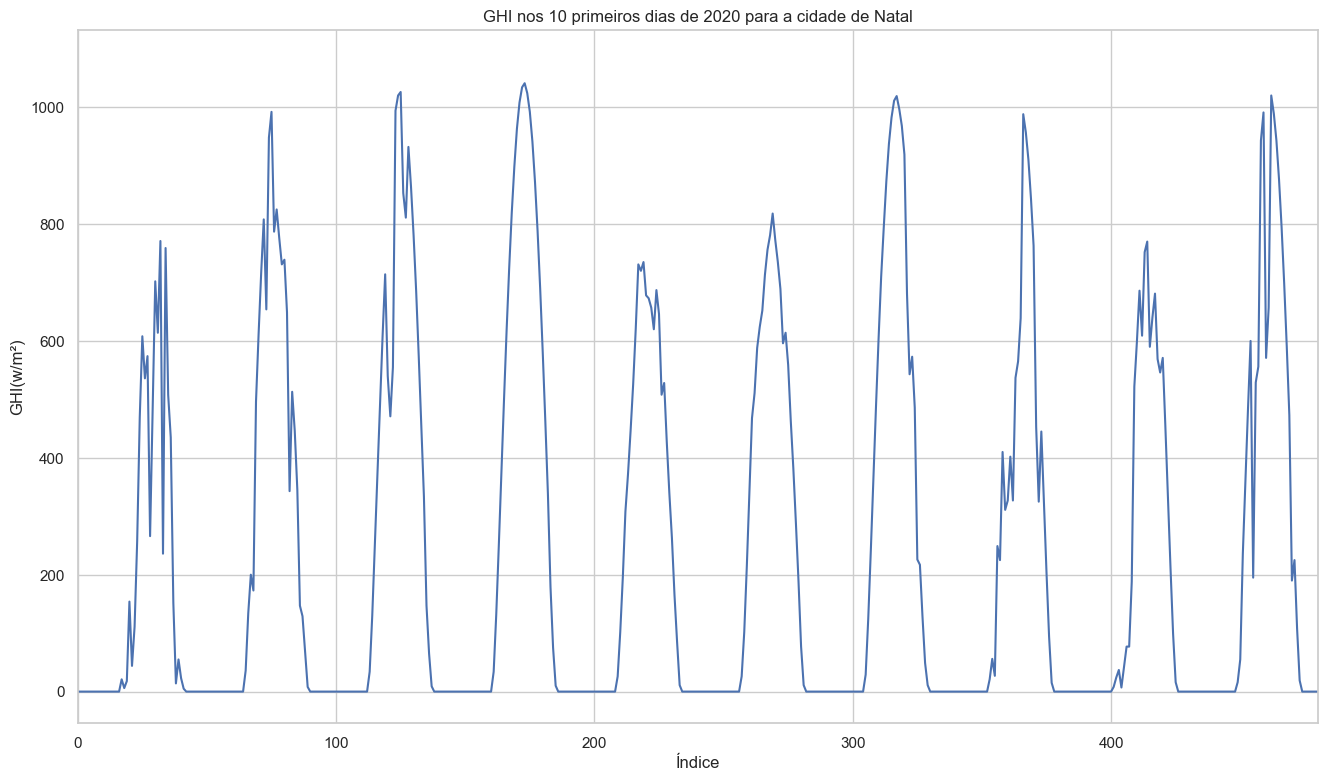

In [76]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df[df['Year'] == 2020].reset_index(), x='index', y='GHI')
plt.title('GHI nos 10 primeiros dias de 2020 para a cidade de Natal')
plt.xlabel('Índice')
plt.ylabel('GHI(w/m²)')
plt.xlim(0, 48*10)  # Limita o eixo x para mostrar apenas 10 dias
plt.savefig('GHI_10_dias_Natal.png', dpi=300, bbox_inches='tight')
plt.show()


In [77]:
df_train, df_test = data_scaling_split(df)


In [78]:
df_test

,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,DayOfYear,HourOfDay,City_Natal
0,0.411111,0.578313,0.0,0.734657,0.600000,0.377358,0.341667,0.588889,0.017213,0.000000,0.0
1,0.411111,0.578313,0.0,0.734657,0.600000,0.377358,0.338889,0.577778,0.017213,0.000000,0.0
2,0.400000,0.578313,0.0,0.742468,0.533333,0.377358,0.336111,0.577778,0.017213,0.258819,0.0
3,0.388889,0.578313,0.0,0.753850,0.533333,0.377358,0.330556,0.555556,0.017213,0.258819,0.0
4,0.388889,0.578313,0.0,0.752957,0.533333,0.377358,0.327778,0.544444,0.017213,0.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35035,0.555556,0.638554,0.0,0.644276,0.400000,0.452830,0.319444,0.000000,0.017213,-0.707107,0.0
35036,0.544444,0.662651,0.0,0.672841,0.466667,0.452830,0.319444,0.000000,0.017213,-0.500000,0.0
35037,0.544444,0.662651,0.0,0.672841,0.466667,0.471698,0.319444,0.000000,0.017213,-0.500000,0.0
35038,0.533333,0.662651,0.0,0.693595,0.466667,0.471698,0.319444,0.000000,0.017213,-0.258819,0.0


# Definição dos modelos.

In [79]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Camada GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada de saída
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        # Se hidden não for fornecido, inicializa com zeros
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        
        # Passa pela GRU
        out, hidden = self.gru(x, hidden)
        
        # Aplica a camada linear apenas na última saída temporal
        out = self.fc(out[:, -1, :])  # Pega apenas o último timestep
        
        return out
    
    def init_hidden(self, batch_size):
        # Inicializa o estado oculto com zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [80]:
# Implementação de um LSTM simples
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        else:
            h_0, c_0 = hidden

        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [81]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas de regularização
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Inicialização dos pesos
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        
        # Pega apenas a última saída da sequência
        out = lstm_out[:, -1, :]
        
        # Regularização e camadas densas
        out = self.dropout1(out)
        out = self.batch_norm(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        
        return out

In [82]:
#Modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas de regularização
        self.dropout1 = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Inicialização dos pesos
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        gru_out, _ = self.gru(x)
        
        # Pega apenas a última saída da sequência
        out = gru_out[:, -1, :]
        
        # Regularização e camadas densas
        out = self.dropout1(out)
        out = self.batch_norm(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        
        return out

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

# Função para treinamento do modelo.

In [ ]:
def train_model(model, train_loader, test_loader, epochs, lr, patience=15, weight_decay=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

    best_test_loss = float('inf')
    patience_counter = 0
    train_losses = []
    test_losses = []
    best_model_state = None

    for epoch in range(epochs):
        # Treino
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze(-1)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Teste
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss += criterion(outputs.squeeze(), y_batch).item()

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        scheduler.step(test_loss)

        # Early stopping baseado no teste
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping na época {epoch+1}")
                break

        if (epoch + 1) % 20 == 0:
            print(f'Época {epoch+1}/{epochs}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, test_losses, best_test_loss


# Função para plotar as perdas.

In [84]:
def plot_losses(train_losses, test_losses):
    """Plota as perdas de treino e teste """
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='green')
    plt.title('Losses durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [85]:
#Convertendo os dados de treino, validação e teste para tensores PyTorch
ghi_values_train = torch.tensor(df_train['GHI'].values, dtype=torch.float32).unsqueeze(-1)
ghi_values_test = torch.tensor(df_test['GHI'].values, dtype=torch.float32).unsqueeze(-1)

X_train = ghi_values_train[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_train = ghi_values_train[1:].squeeze(-1)          # shape: (N-1, 1)
X_test = ghi_values_test[:-1].unsqueeze(1)  # shape: (N-1, 1, 1)
y_test = ghi_values_test[1:].squeeze(-1)          # shape: (N-1, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




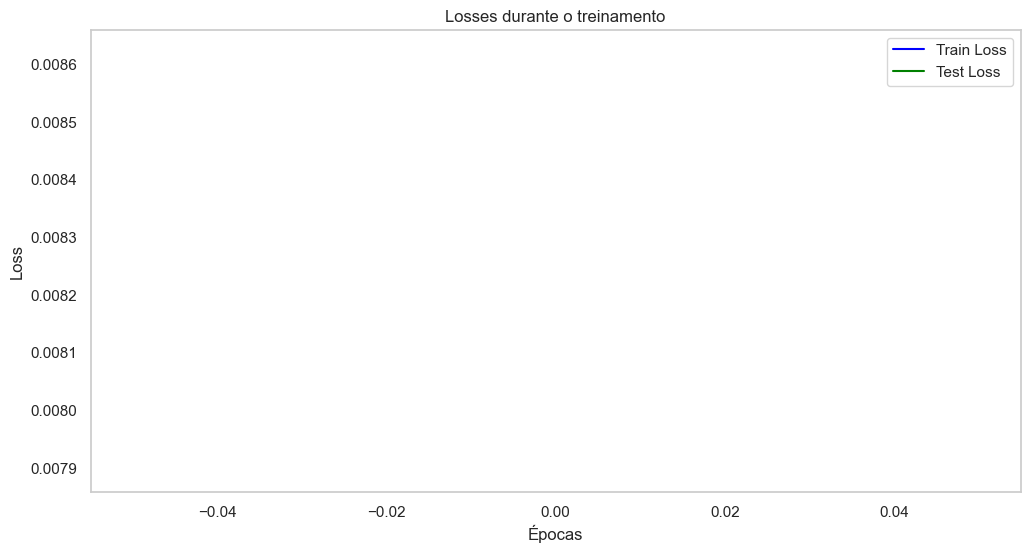

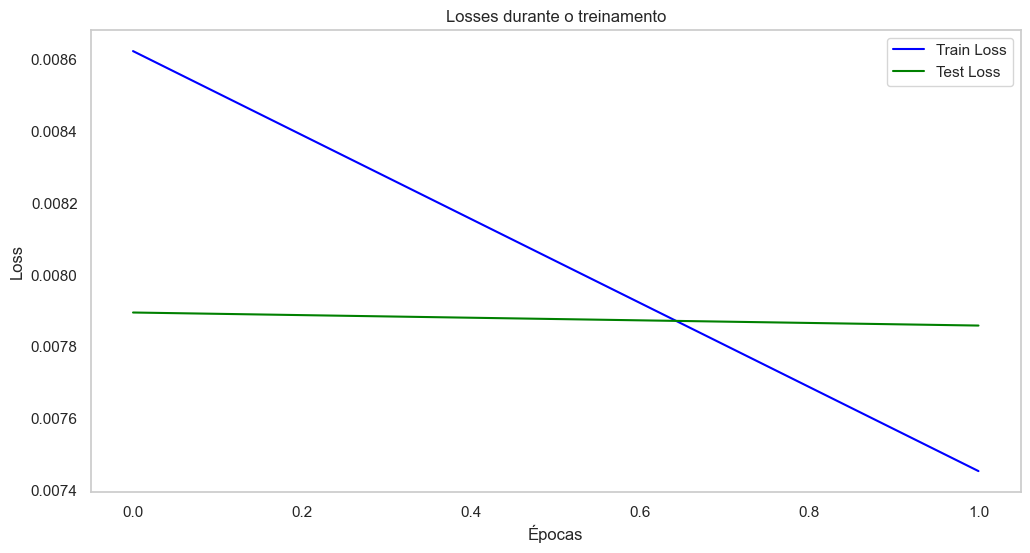

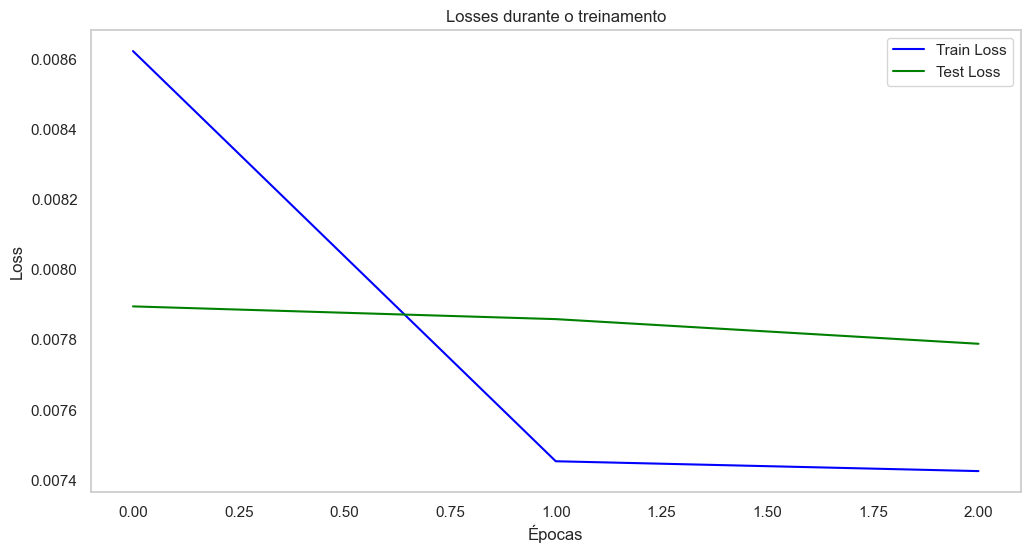

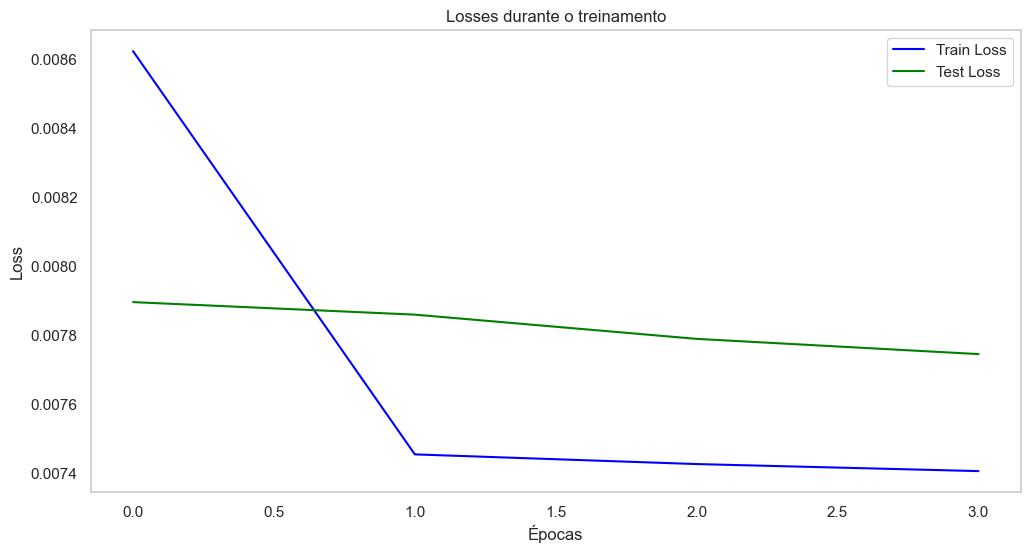

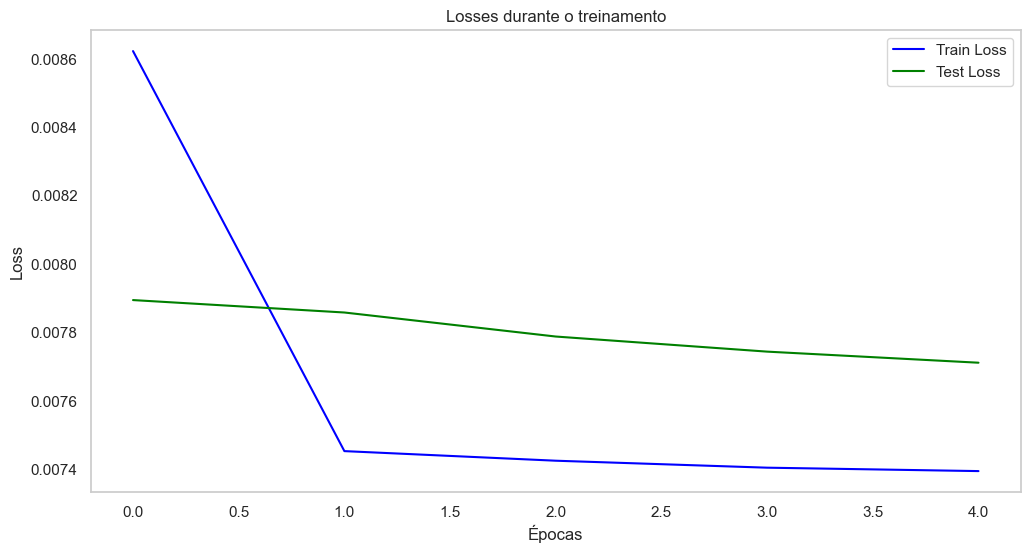

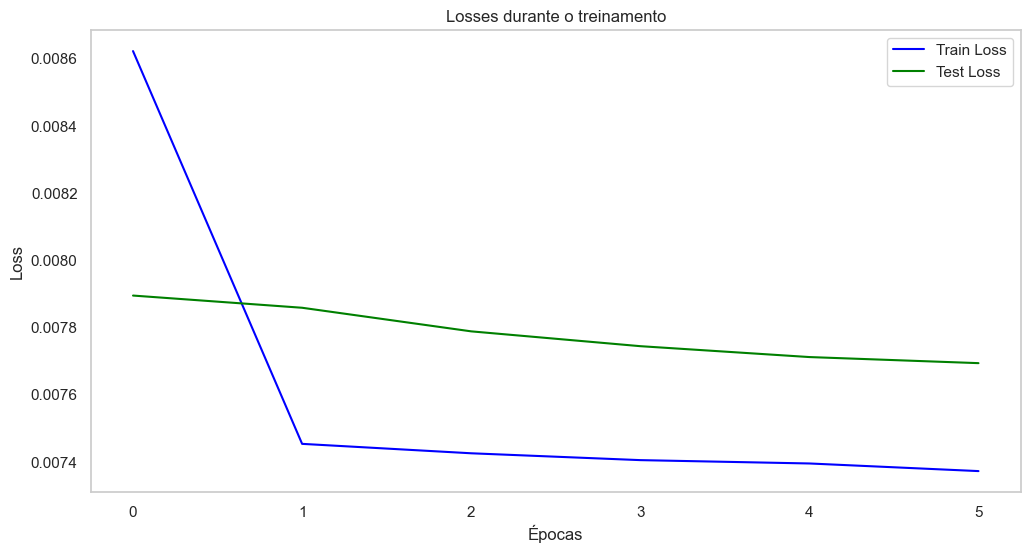

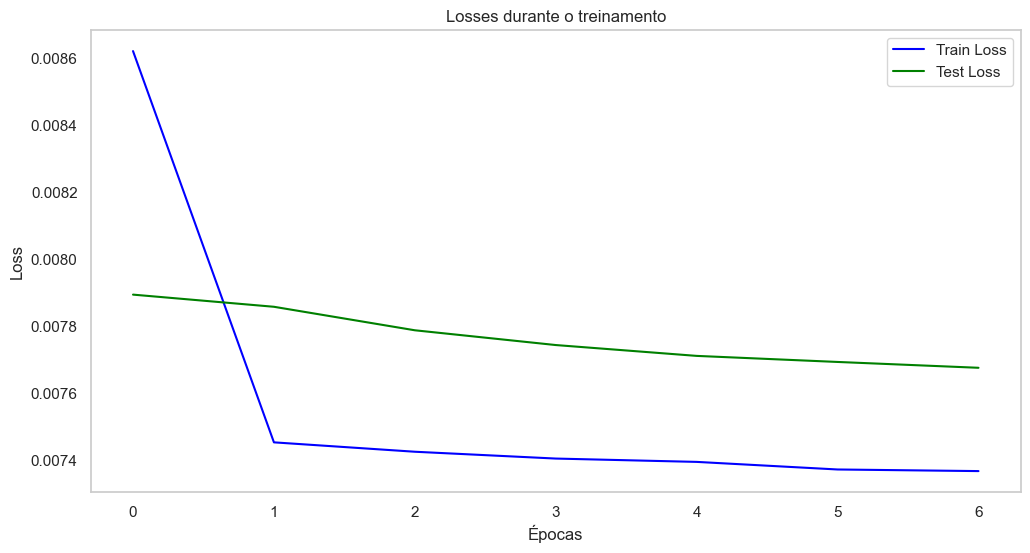

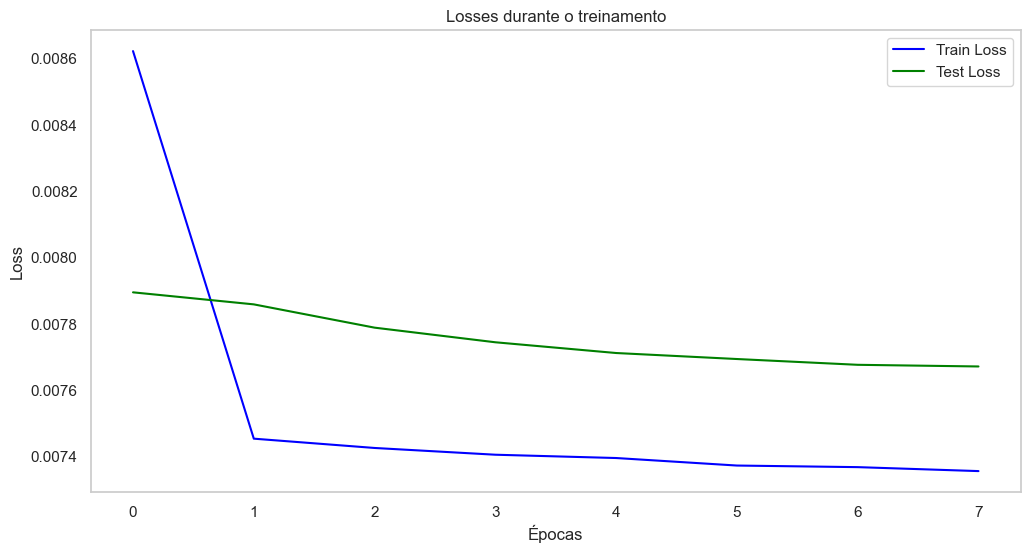

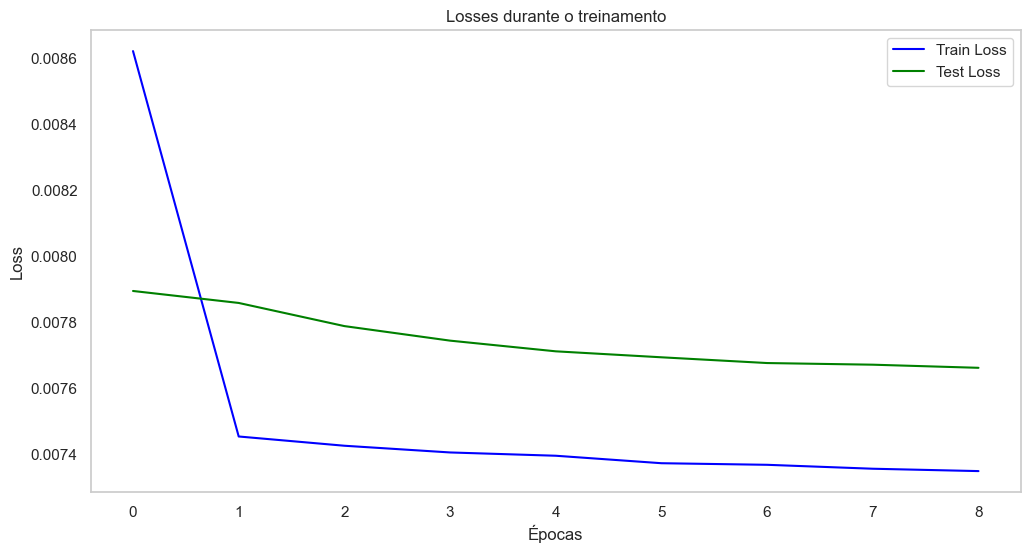

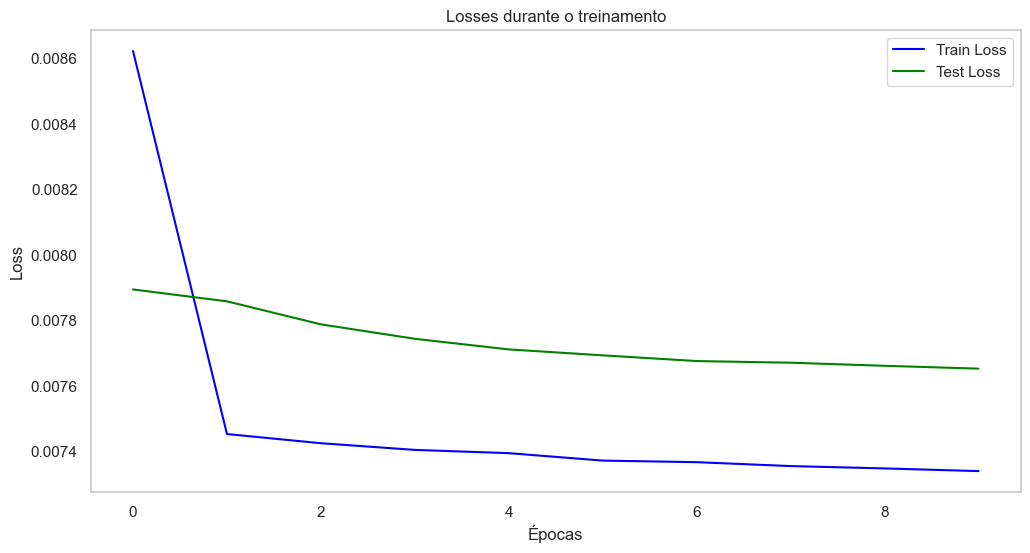

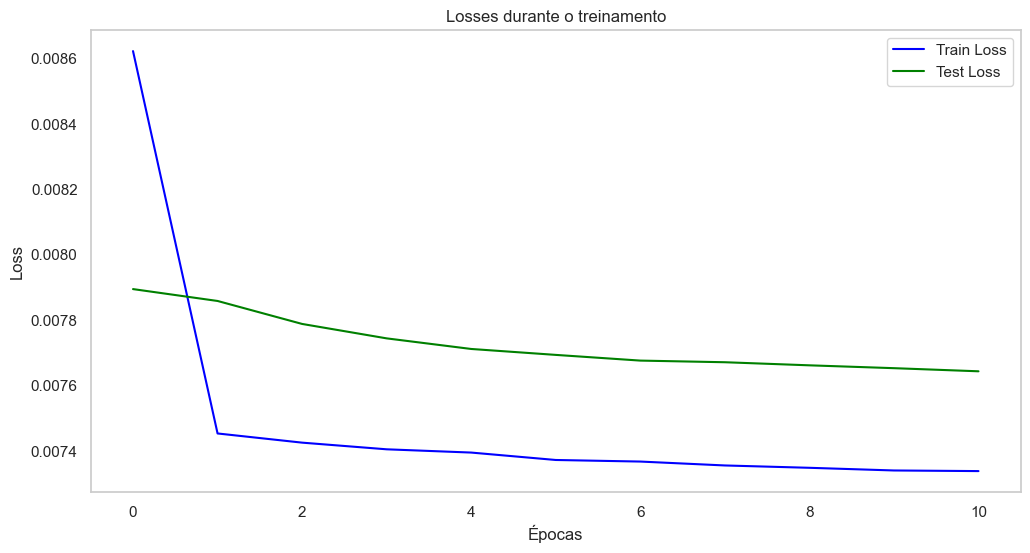

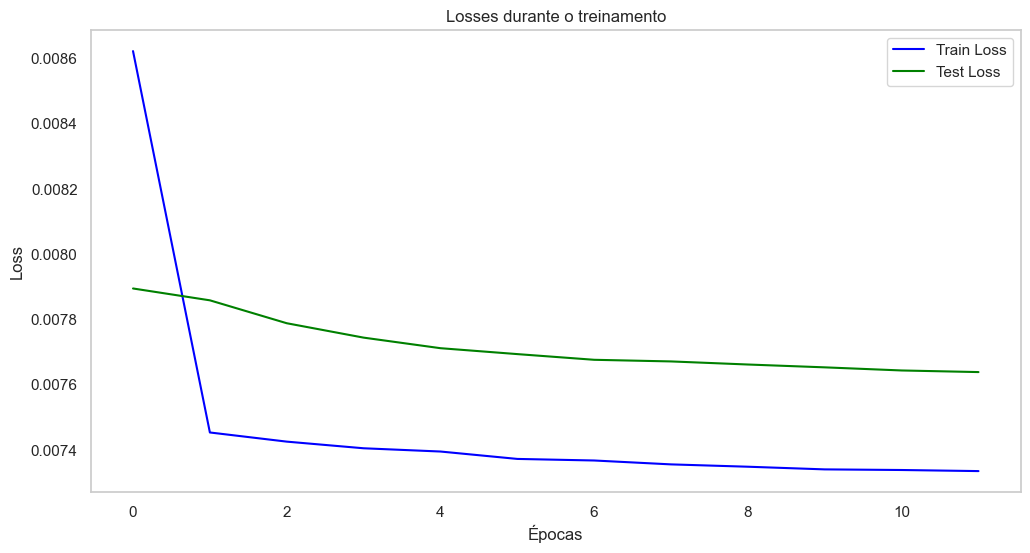

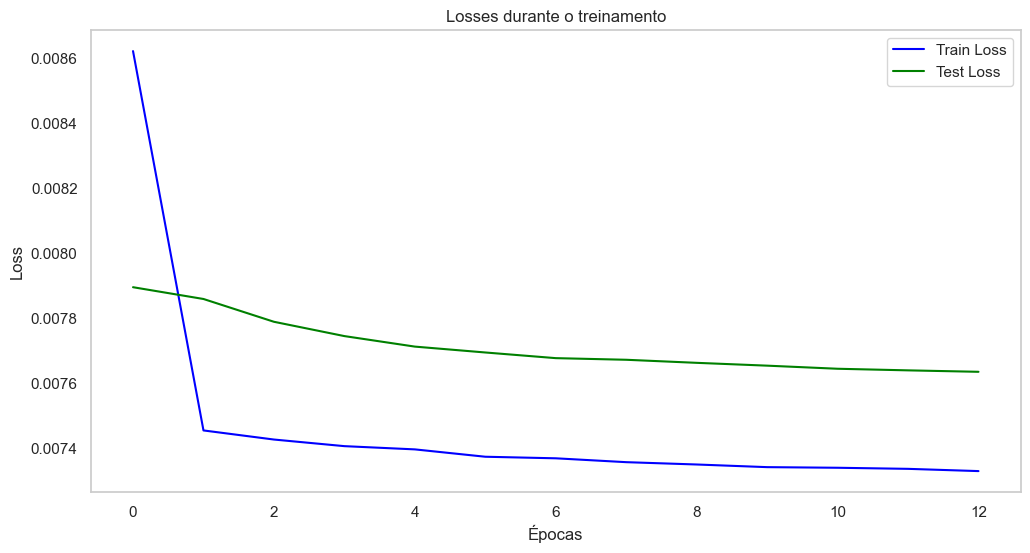

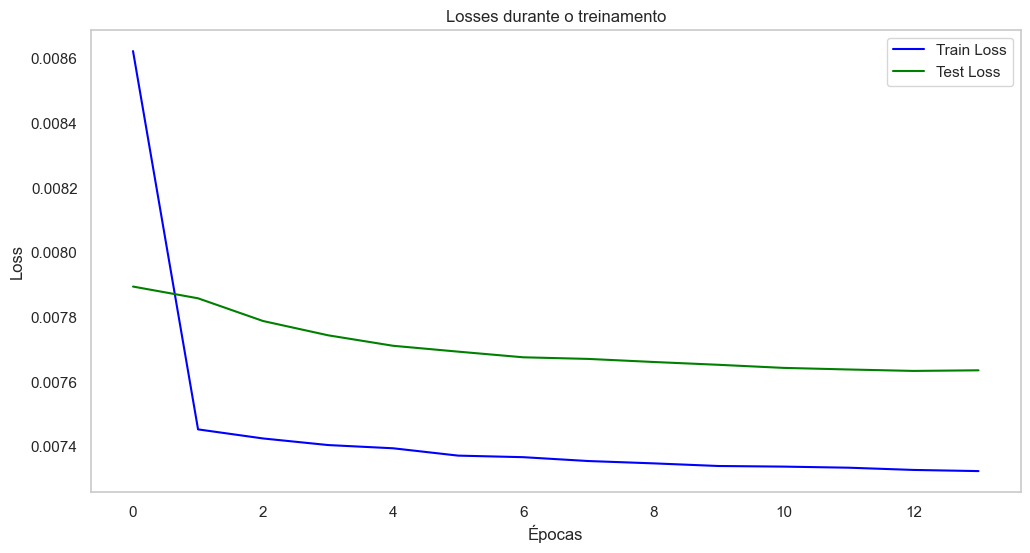

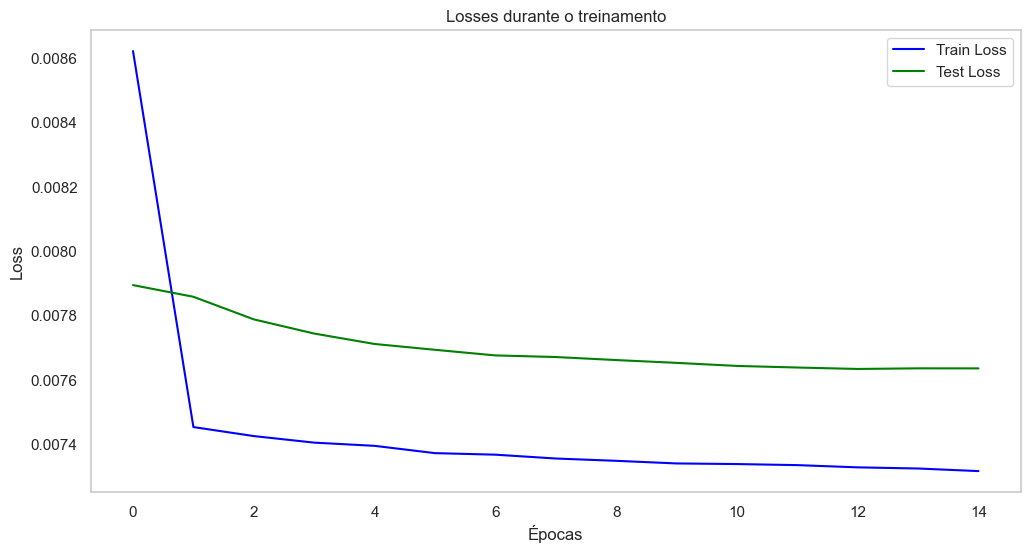

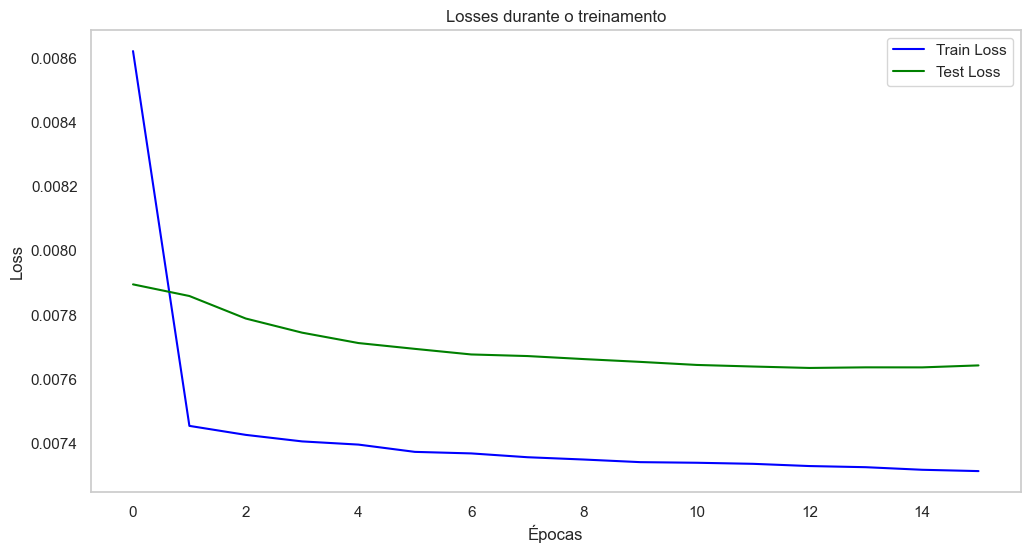

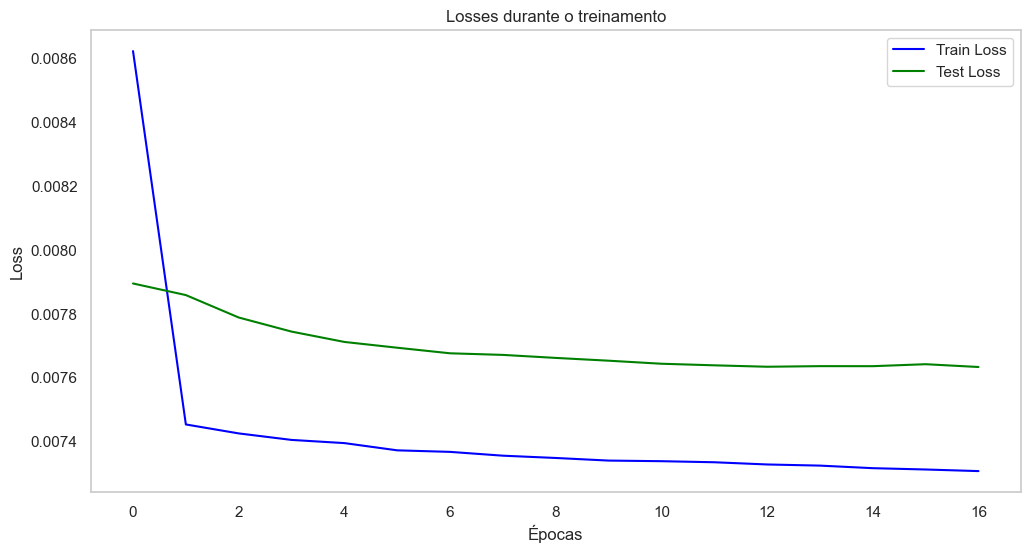

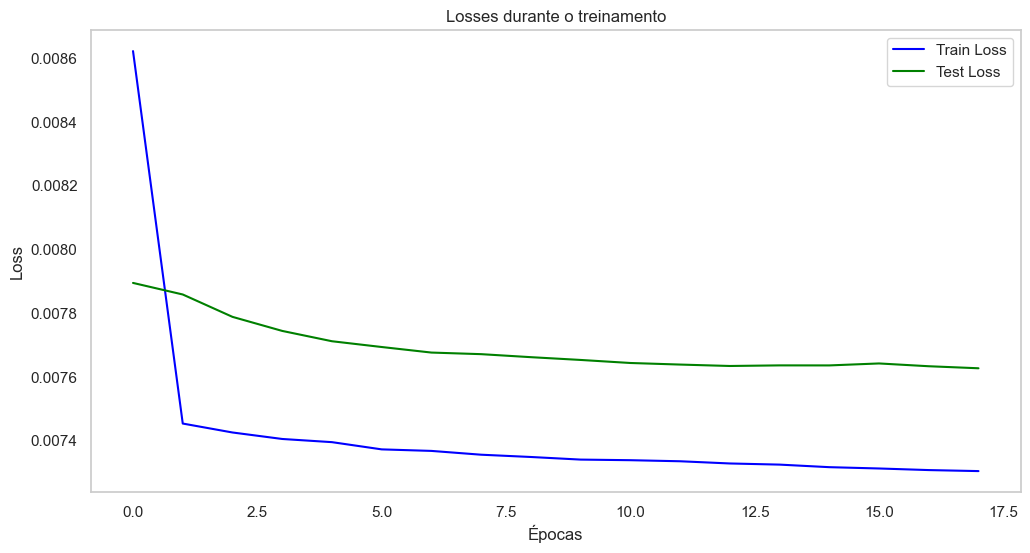

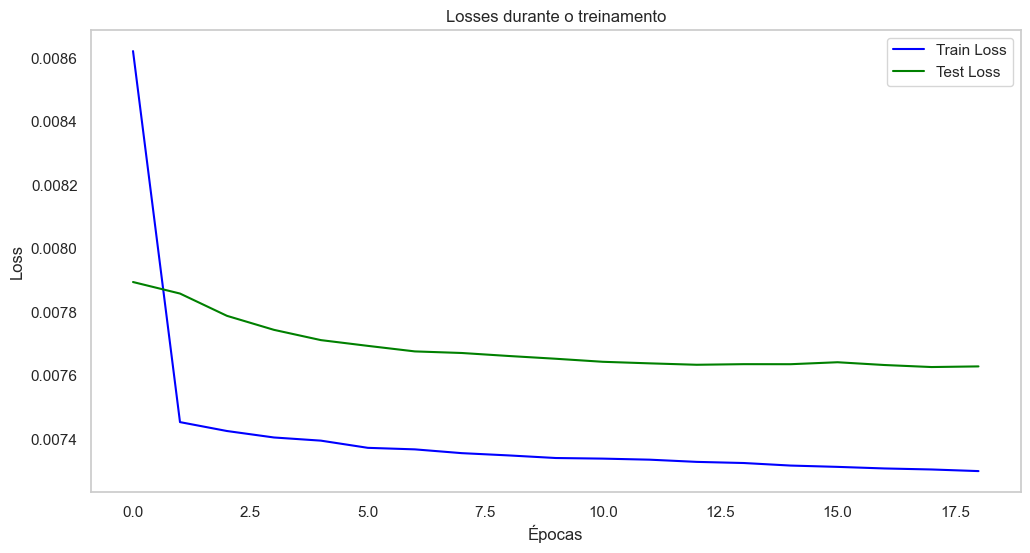

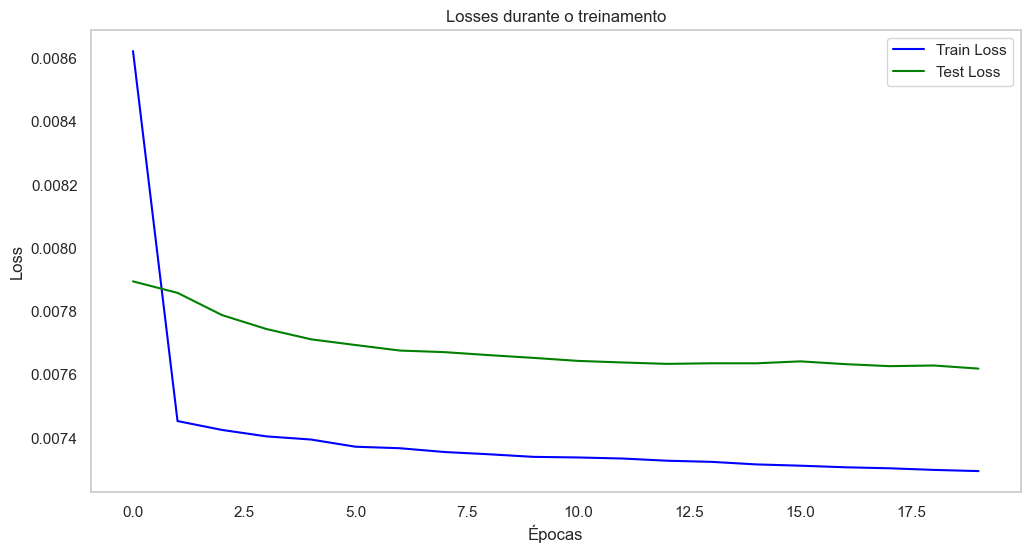

Época 20/100: Train Loss: 0.007296, Test Loss: 0.007619


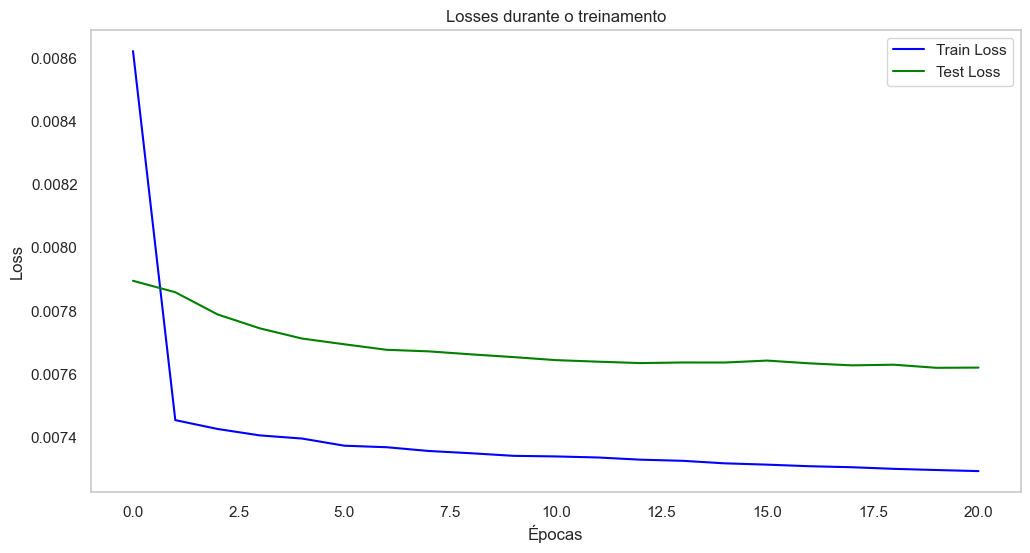

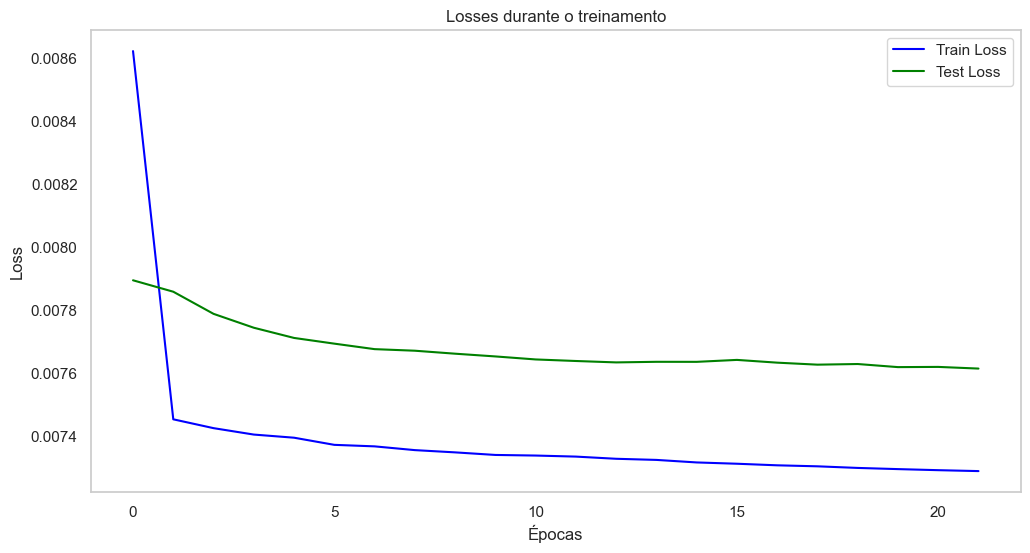

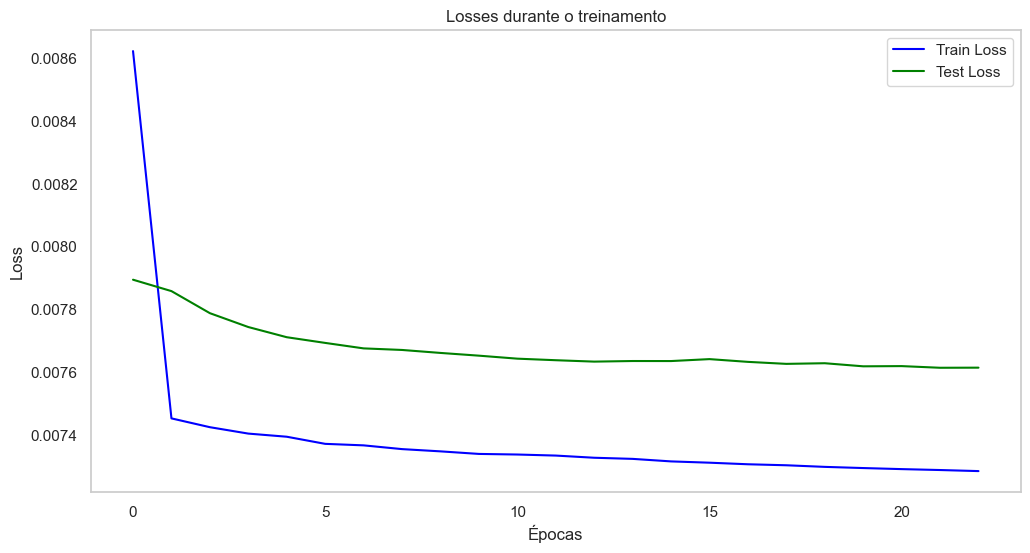

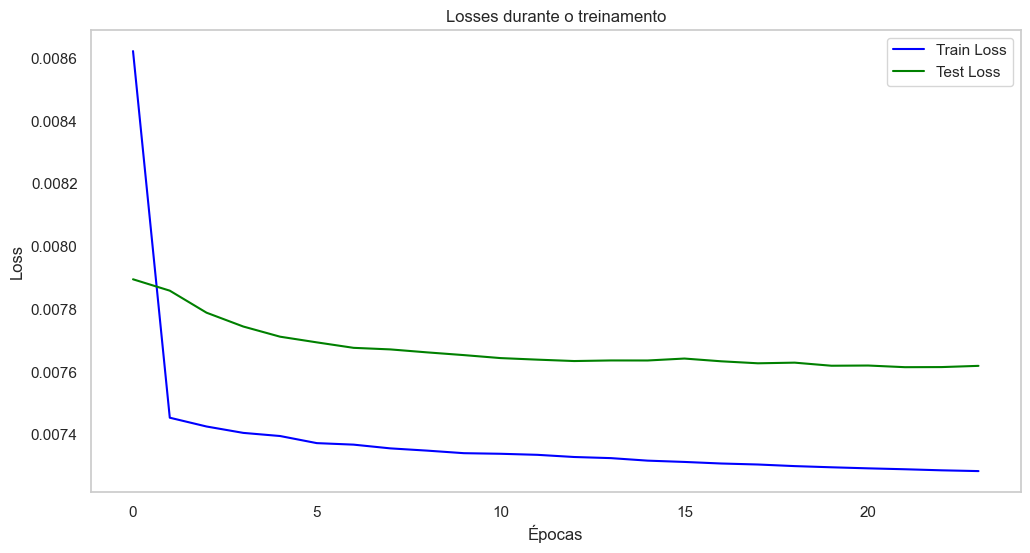

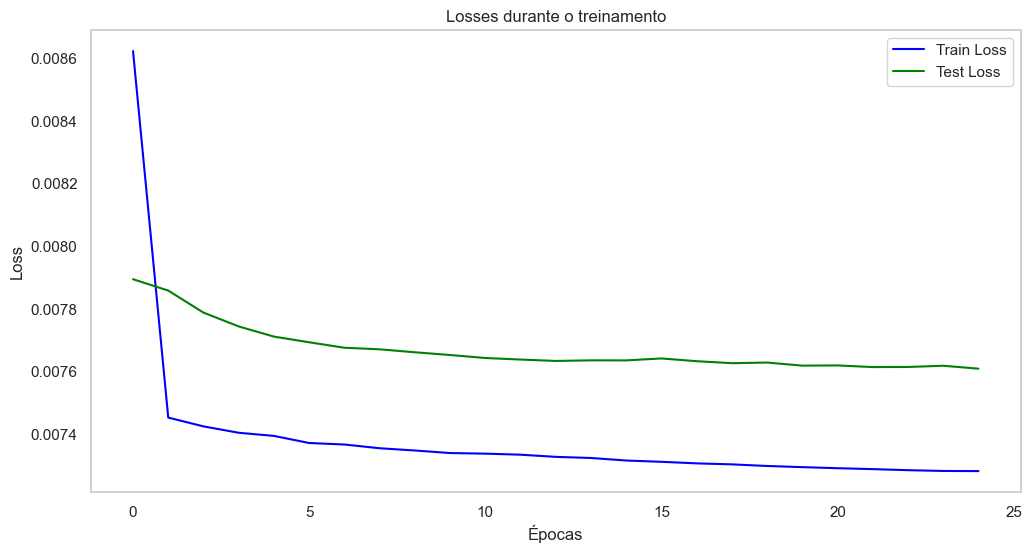

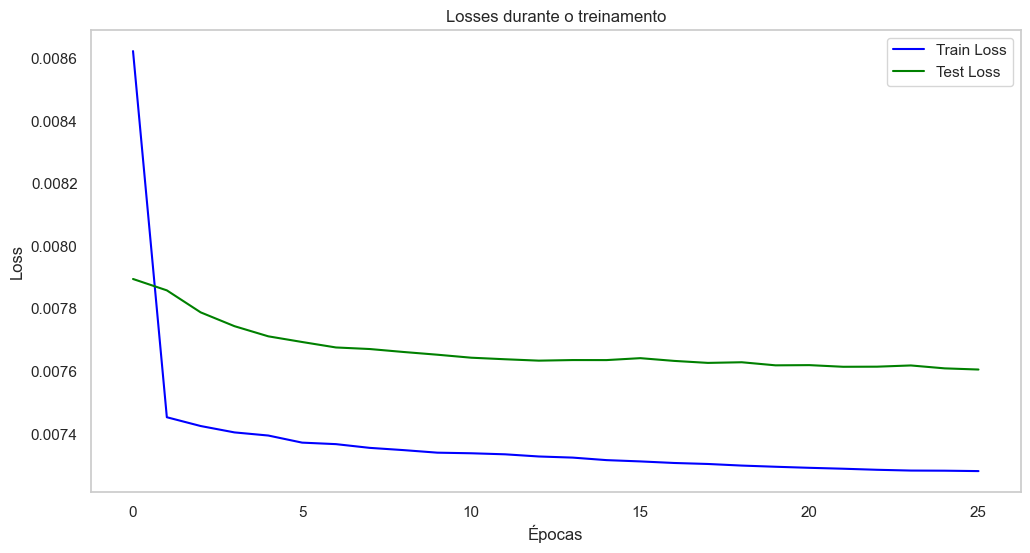

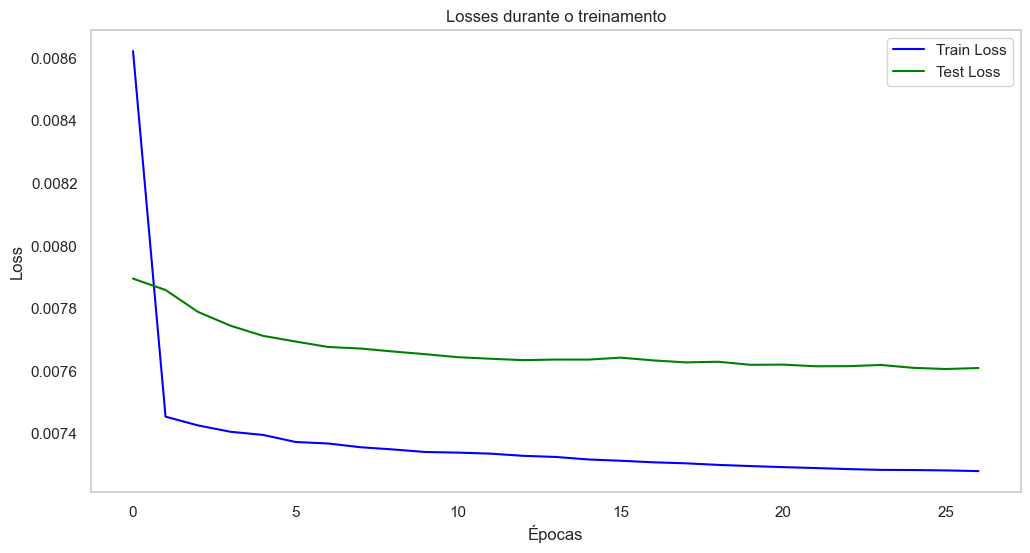

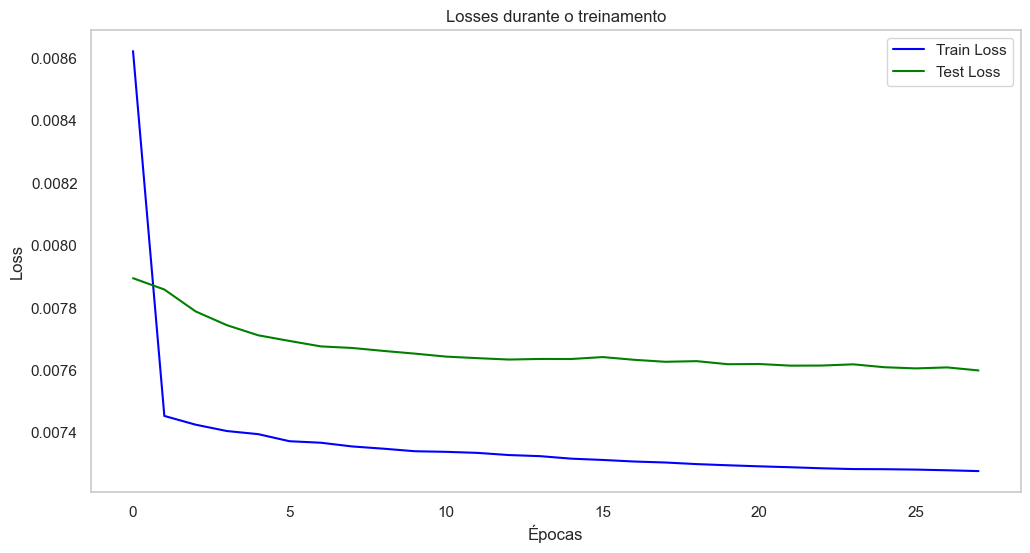

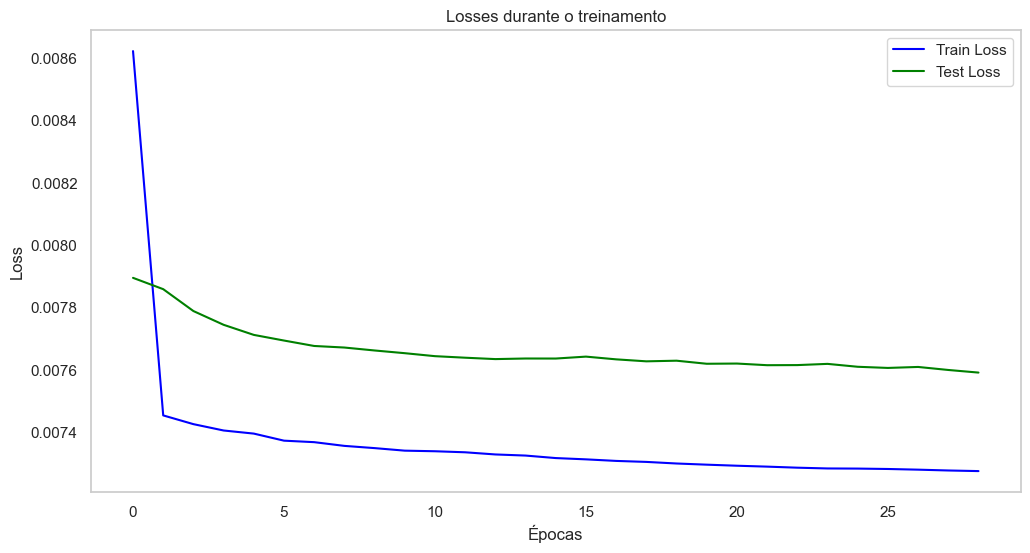

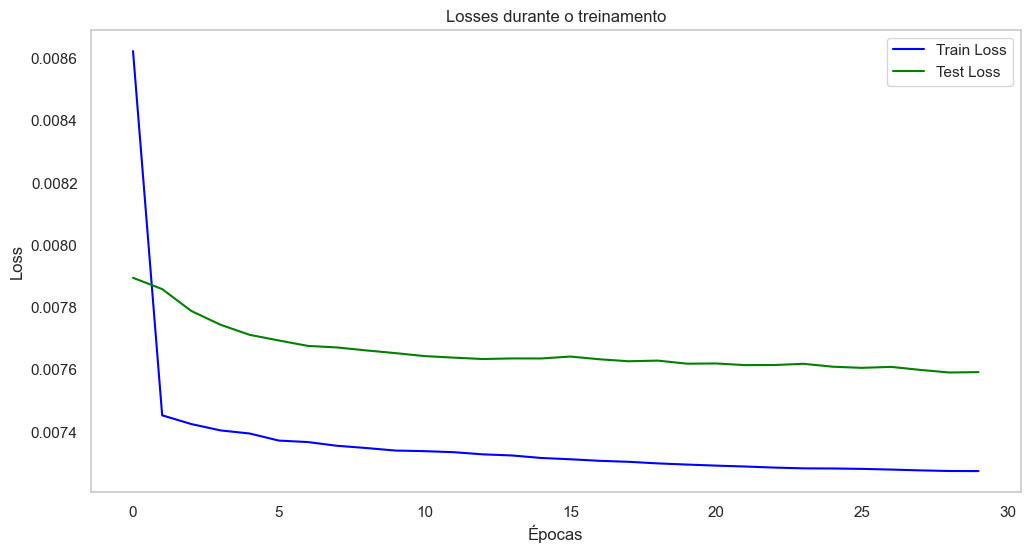

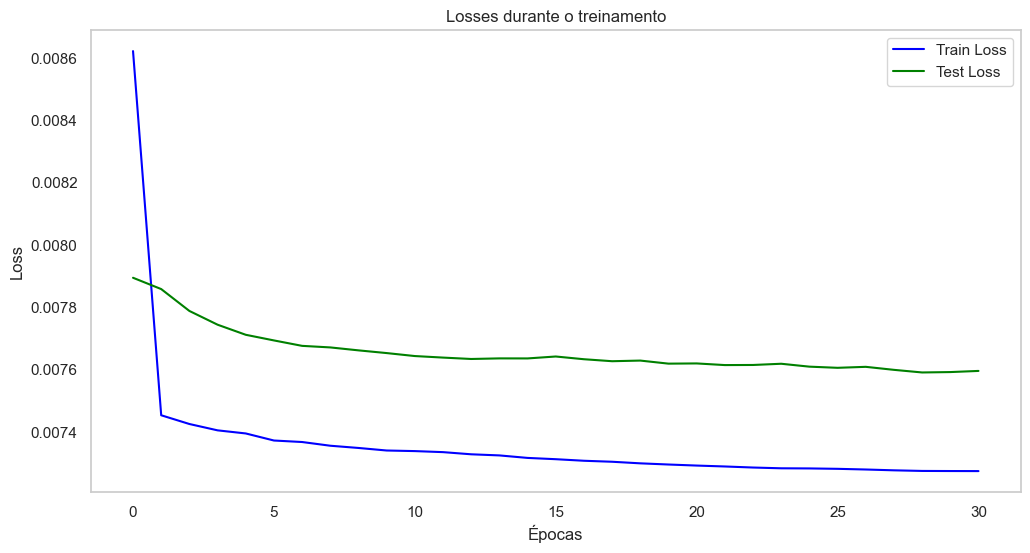

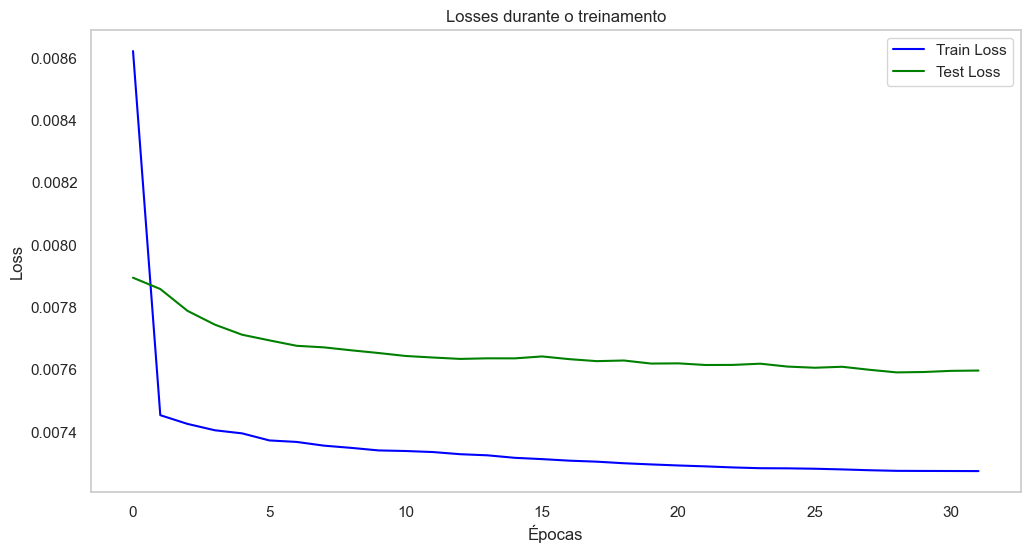

KeyboardInterrupt: 

In [88]:
input_size = X_train.shape[-1]
model = SimpleGRU(input_size=input_size, hidden_size=20, output_size=1, num_layers = 2).to(device)
train_losses, test_losses, best_test_loss = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=100,
    lr=0.01,
    patience=15,
    weight_decay=1e-5
)

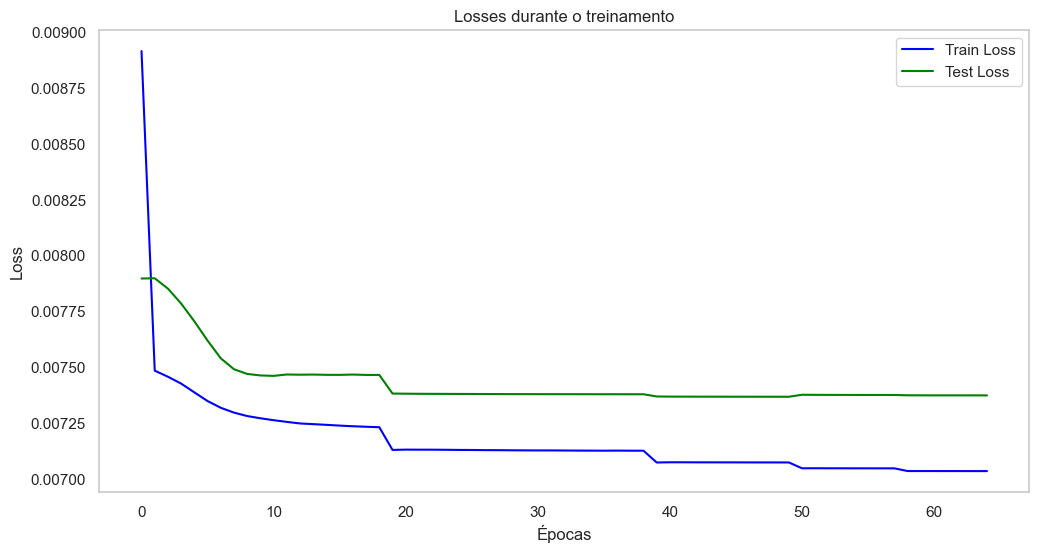

In [87]:
plot_losses(train_losses, test_losses)